In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as pp
import numpy as np
import csv
import os

import time
import sys

from matplotlib import cm
from numpy import arctan, log, pi, sqrt


%matplotlib notebook

os.chdir("D:")

# Mesh Generation:

In [2]:
nx  = 50
ny  = 50
nt  = 100

xmin = -5
xmax = 5
ymin = 0
ymax = 10

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
dt = 0.001

x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(ymin, ymax, ny)

X, Y = np.meshgrid(x, y)

L = ymax

xs = int(np.size(nx)/2) #this is x range because it is half in negetive and half in positive part

# Creating fields for equation parameters:

In [3]:
u  = np.zeros((ny, nx))
un = np.zeros((ny, nx))

v  = np.zeros((ny, nx))
vn = np.zeros((ny, nx))

T  = np.zeros((ny, nx))
Tn = np.zeros((ny, nx))

C  = np.zeros((ny, nx))
Cn = np.zeros((ny, nx))

H  = np.zeros((ny, nx))
Hx = np.zeros((ny, nx))
Hy = np.zeros((ny, nx))

# Fluid Specs:

In [4]:
nu  = 0.801-6
mu  = 0.001
Cp  = 4178
Cv  = 4.15
tau = Cp/Cv
rho = 997.5
kf  = 0.6129 #heat transfer coeff. fluid
kp  = 80.4   #heat transfer coeff. particle

# Flow Specs:

In [5]:
a      = 1.2
beta   = 0.001 #unsteadiness paramepter
mu0    = 4e-7*pi
M      = 8.6e5
h      = 12.5e-6   #height of magnet
w      = 25e-6     #width of magnet
eps    = 0.1
Q0     = 30 #heat generation
H0     = 253843.822358745
alpha = 0.143e-6  #thermal diffusivity

In [6]:
V0    = -5
ts    = nt*dt #Final time
Cf    = 0.02 #0.2/100
Cinf  = 0.04 #0.4/100
delC  = Cf - Cinf
Tinf  = 333.15 #333
Tf    = 303.15 #293 #initial Temp
delT  = Tf - Tinf
Pr    = nu/alpha
Re    = abs(V0*L/nu)
# Nu = 0.05928 * ((0.44 + Cf)**0.536) * Re**0.7 * Pr**0.4
Nu    = 0.2497091666
Sh    = 0.922369

In [7]:
kB = 1.385e-23
dp = 1e-8 #particle diameter
TF = (Tinf + Tf)/2 #Film temperature
DB = (kB*TF)/(3 * pi * mu * dp) #Brownian motion coeff.
DT = (mu/rho) * (0.26 * kf/(kf + kp)) #Thmoforesis coeff

In [8]:
u.fill(a*L/V0) 
v.fill(V0)
T.fill(Tf)
C.fill(Cf)

# Calculating magnitization intensity (H):

In [9]:
def Hcalc(i, j):
    H = (sqrt(M**2*(-log(((-h + j)**2 +
                          (-w + i)**2)/((h + j)**2 +
                          (-w + i)**2)) +
                          log(((-h + j)**2 + (w + i)**2)/((h + j)**2 +
                          (w + i)**2)))**2/(16*pi**2) +
                          M**2*(-arctan(2*h*(-w + i)/(-h**2 + j**2 +
                          (-w + i)**2)) + arctan(2*h*(w + i)/(-h**2 + j**2 + (w + i)**2)))**2/(4*pi**2)))
    H = H/H0
    return H

# Derivative of H: $\frac{\partial H}{\partial x}$ or $\frac{\partial H}{\partial y}$

In [10]:
def Hdiff(i, j, d, var):
    if (var == "x"):
        dH = (Hcalc(i+1, j) - Hcalc(i, j))/d
    elif (var == "y"):
        dH = (Hcalc(i, j+1) - Hcalc(i, j))/d
    return dH

In [11]:
#negetive x
for i in range(xs):
    for j in range(ny):
        H[j, i] = Hcalc(-i, j)
        Hx[j, i] = Hdiff(i, j, dx, "x")
        Hy[j, i] = Hdiff(i, j, dy, "y")
        
#positive x
for i in range(xs, nx):
    for j in range(ny):
        H[j, i] = Hcalc(i, j)
        Hx[j, i] = Hdiff(i, j, dx, "x")
        Hy[j, i] = Hdiff(i, j, dy, "y")

# 1st Derivative: $\frac{\partial F}{\partial x}$ or $\frac{\partial F}{\partial y}$

In [12]:
def diff1(i, j, F, d, var):
    if (var == "x"):
        dF = (F[j, i+1] - F[j, i-1])/(2*d)
    elif (var == "y"):
        dF = (F[j+1, i] - F[j-1, i])/(2*d)
    return dF

# 2nd Derivative: $\frac{\partial^2 F}{\partial x^2}$ or $\frac{\partial^2 F}{\partial y^2}$

In [13]:
def diff2(i, j, F, d, var): #derivative 2
    if (var == "x"):
        d2F = (F[j, i+1] - 2*F[j, i] + F[j, i-1])/(2*d)
    elif (var == "y"):
        d2F = (F[j+1, i] - 2*F[j, i] + F[j-1, i])/(2*d)
    return d2F

# Calculate U Field:

In [14]:
def uCalc(t):
    un = u.copy()
    
    #Boundary Condition:
    v[-1, :] = 0 #y = oo
    v[0, :] = -1/(V0 * (1 - beta*ts*t)) #y = 0
    #
    #negetive x
    for i in range(xs):
        u[0, i]  = (a*L*(-i))/(V0 * (1 - beta*ts*t)) #y = 0
        u[-1, i] = (a*L*(-i))/(V0 * (1 - beta*ts*t)) #y = oo

        for j in range(1, size(ny)-1):
            u[j, i] = (((ts*dt)/V0) * ((a*L*(-i)*(a+beta))/(1-beta*ts*t) + 
                           ((nu*V0)/(L**2)) * diff2(i, j, un, dy, "y") + 
                           ((1/rho)*mu0*M*H0/L) * Hx[j, i] -
                           (((V0**2)/L) * un[j, i] * diff1(i, j, un, dx, "x") +
                           (((V0**2)/L) * v[j, i] * diff1(i, j, un, dy, "y"))) +
                           un[j, i]))
    #
    #positive x
    for i in range(xs, nx):
        u[0, i]  = (a*L*i)/(V0 * (1 - beta*ts*t)) #y = 0
        u[-1, i] = (a*L*i)/(V0 * (1 - beta*ts*t)) #y = oo
        
        for j in range(1, np.size(ny)-1):
            u[j, i] = (((ts*dt)/V0) * ((a*L*i*(a+beta))/(1-beta*ts*t) + 
                           ((nu*V0)/(L**2)) * diff2(i, j, un, dy, "y") + 
                           ((1/rho)*mu0*M*H0/L) * Hdiff(i, j, dx, "x") -
                           (((V0**2)/L) * un[j, i] * diff1(i, j, un, dx, "x") +
                           (((V0**2)/L) * v[j, i] * diff1(i, j, un, dy, "y"))) +
                           un[j, i]))
    #                
    udiff = (np.sum(u) - np.sum(un))/np.sum(u)
    return (u, v, un, udiff)

# Calculate T Field:

In [15]:
def TCalc(t):
    Tn = T.copy()
    
    for i in range(np.size(nx)):
        for j in range(1, np.size(ny)-1):
            T[j, i] = (((ts*dt)/delT) * (tau *
                             ((DB/(L**2)) * delC * (delT) * diff1(i, j, Cn, dy, "y") * diff1(i, j, Tn, dy, "y")) + 
                             (DT/(Tinf * (L**2))) * (delT**2) * ((diff1(i, j, Tn, dy, "y"))**2)) + 
                             (Q0/(rho*c)) * delT * (Tn[j, i] + 1) +
                             ((alpha * delT)/L) * diff2(i, j, Tn, dy, "y") - 
                             ((V0/L) * un[j, i] * delT * diff1(i, j, Tn, dx, "x") + 
                             (V0/L) * v[j, i] * delT * diff1(i, j, Tn, dy, "y"))
                              + Tn[j, i])
        #Boundary Condition:
        T[0, :]  = T[1, :]/((Nu * dy) + 1) #y = 0
        T[-1, :] = -1                      #y = oo
    
    Tdiff = (np.sum(T) - np.sum(Tn))/np.sum(T)
    return (T, Tn)

# Calculate C field

In [16]:
def CCalc(t):
    Cn = C.copy()
    
    for i in range(np.size(nx)):
        for j in range(1, np.size(ny)-1):
            C[j, i] = (((ts*dt)/delC) * ((DB/(L**2)) * delC * diff2(i, j, Cn, dy, "y") +
                                    (DT/((L**2)*Tinf)) * delT * diff1(i, j, Tn, dy, "y") - 
                                    ((V0/L) * un[j, i] * delC * diff1(i, j, Cn, dx, "x") + 
                                    (V0/L) * v[j, i] * delC * diff1(i, j, Cn, dy, "y"))) +
                                     Cn[j, i])
    #Boundary Condition:
    C[0, :]  = C[1, :]/((Nu * dy) + 1) #y = 0
    C[-1, :] = -1                      #y = oo
    
    Cdiff = (np.sum(C) - np.sum(Cn))/np.sum(C)
    return (C, Cn, Cdiff)

# FHD Solver:

In [25]:
STEP = 100

udiff     = 1
Tdiff     = 1
Cdiff     = 1
accu      = 0.001

iteration = []

udiffDat = []
TdiffDat = []
CdiffDat = []
CORD     = []

stepcount = 0

while 1: #(abs(udiff) > accu) or (abs(Tdiff) > accu) or (abs(Cdiff) > accu):
    for t in range(nt+1):
        (u, v, un, udiff) = uCalc(t)
        (T, Tn, Tdiff) = TCalc(t)
        (C, Cn, Cdiff) = CCalc(t)
    
    udiffDat.append(abs(udiff))
    TdiffDat.append(abs(Tdiff))
    CdiffDat.append(abs(Cdiff))
    
    COR = (u*dt)/dx
    COR = COR.max()
    CORD.append(COR)
    
    stepcount += 1
    print("Iteration number: " + str(stepcount) + " | Courant Number: " + str(COR) + "\n")
    print("X_Velocity: " + str(udiff) 
          + " | " + "Temperature: " + str(Tdiff) 
          + " | " + "Concentration: " + str(Cdiff) + "\n")
    print("---------------------------------------------------------------------------\n")
    iteration.append(stepcount)

    if stepcount == STEP:
        print("Calculation is finished!")
        break

Iteration number: 1 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 2 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 3 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 4 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 5 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration 

Iteration number: 44 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 45 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 46 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 47 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 48 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Itera

Iteration number: 91 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 92 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 93 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 94 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 95 | Courant Number: -0.0

X_Velocity: 5.1274296011251796e-05 | Temperature: 0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Itera

# Residuals:

<IPython.core.display.Javascript object>


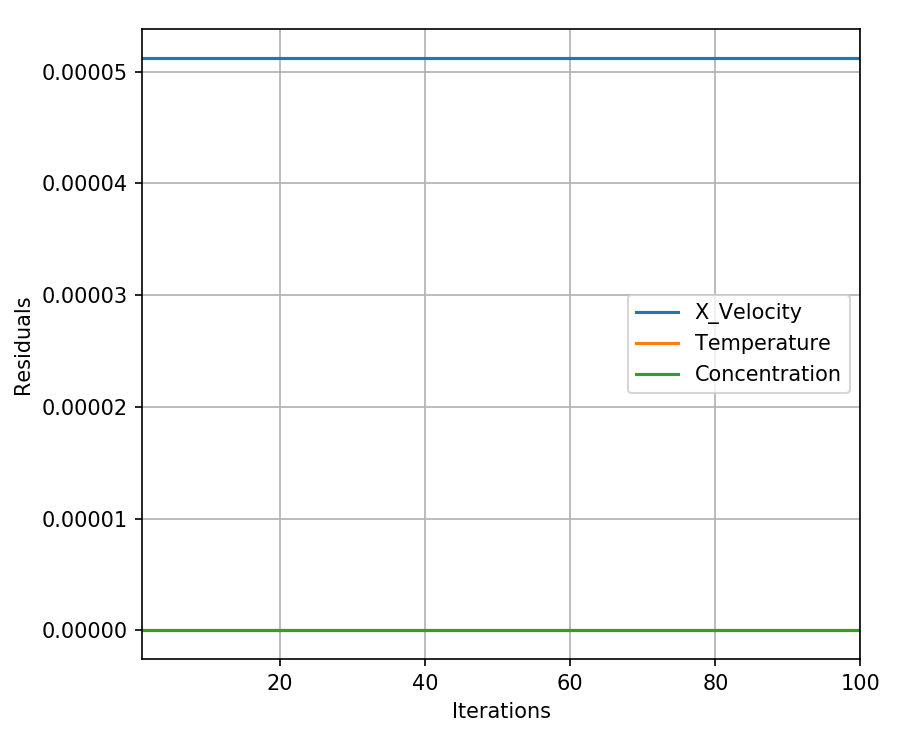

In [26]:
%matplotlib notebook

pp.figure()

pp.autoscale(enable=True, axis='x', tight=True)

pp.plot(iteration, udiffDat, label = "X_Velocity")
pp.plot(iteration, TdiffDat, label = "Temperature")
pp.plot(iteration, CdiffDat, label = "Concentration")
# pp.plot(iteration, CORD, label = "Courant Number")

# pp.grid(True)
pp.legend();
pp.xlabel("Iterations")
pp.ylabel("Residuals")

pp.grid(True)

pp.tight_layout()
fig = pp.gcf()
fig.set_size_inches(6, 5)

# Contours:

<IPython.core.display.Javascript object>


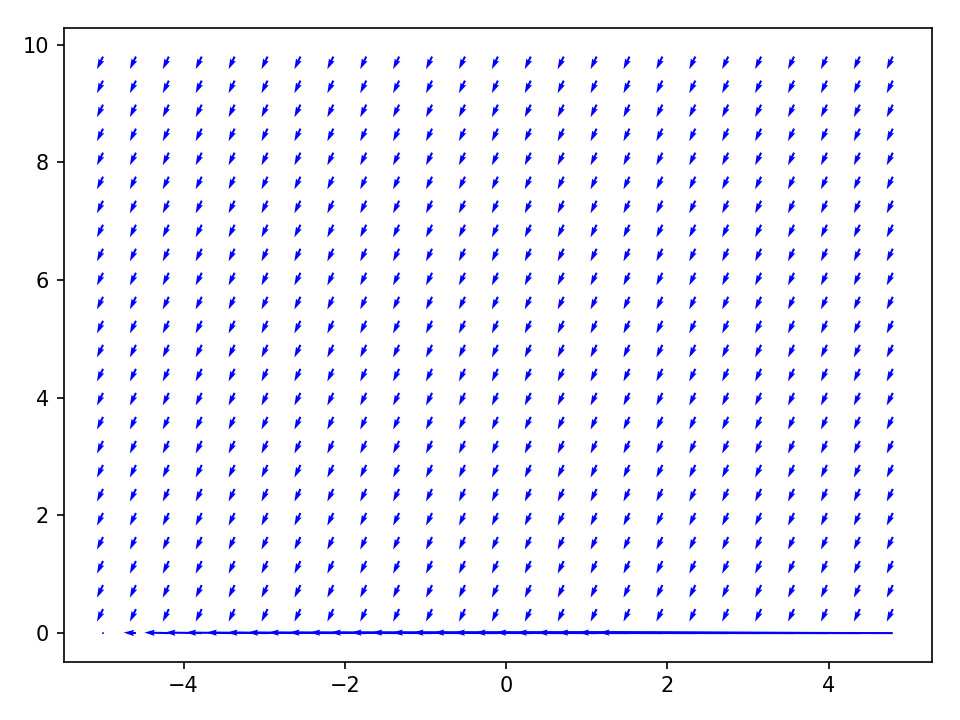

In [27]:
pp.figure()
z = 2
pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z], color = "blue");
pp.tight_layout()

<IPython.core.display.Javascript object>


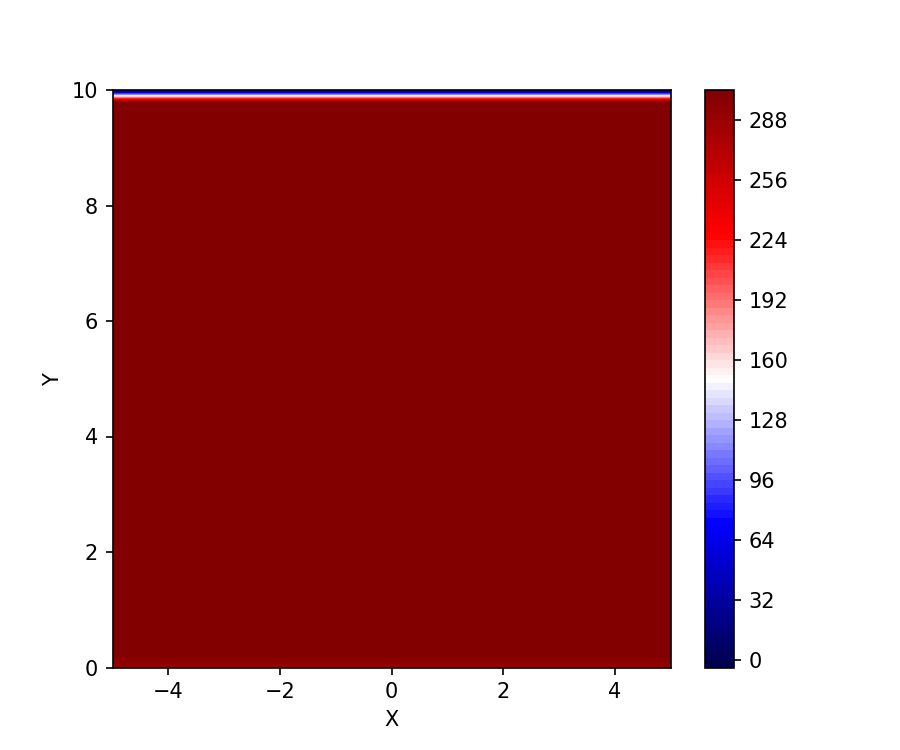

In [20]:
fig = pp.figure()

contour_res = 100

pp.contourf(X, Y, T, contour_res, cmap = "seismic")  
pp.colorbar()

# pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z]) 
pp.xlabel('X')
pp.ylabel('Y')

fig = pp.gcf()
fig.set_size_inches(6, 5)

<IPython.core.display.Javascript object>


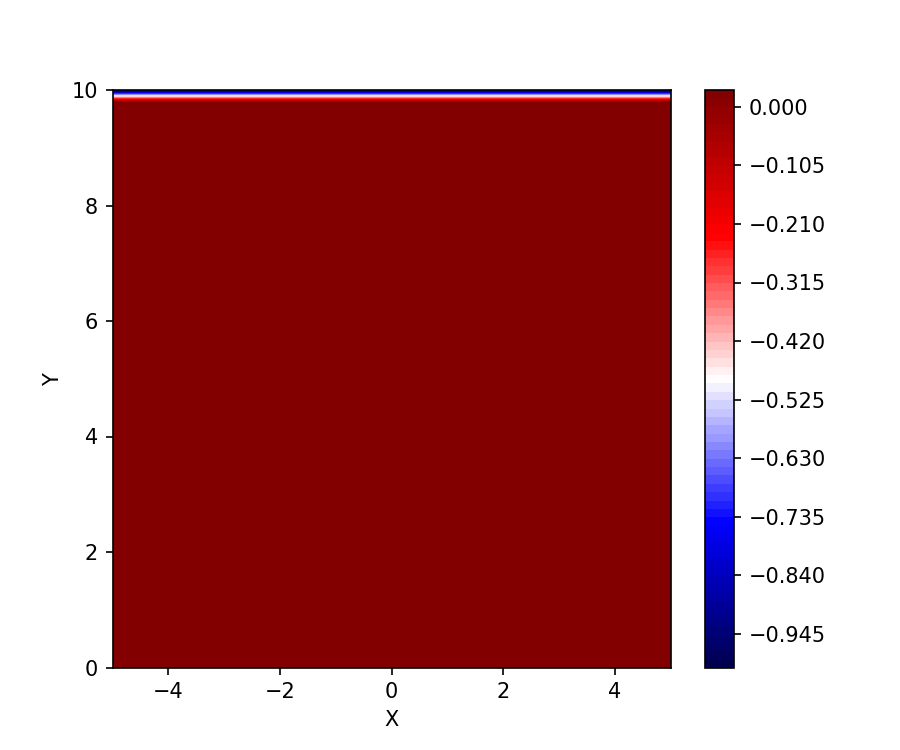

In [21]:
fig = pp.figure()

pp.contourf(X, Y, C, contour_res, cmap = "seismic")  
pp.colorbar()

# pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z]) 
pp.xlabel('X')
pp.ylabel('Y')

fig = pp.gcf()
fig.set_size_inches(6, 5)

<IPython.core.display.Javascript object>


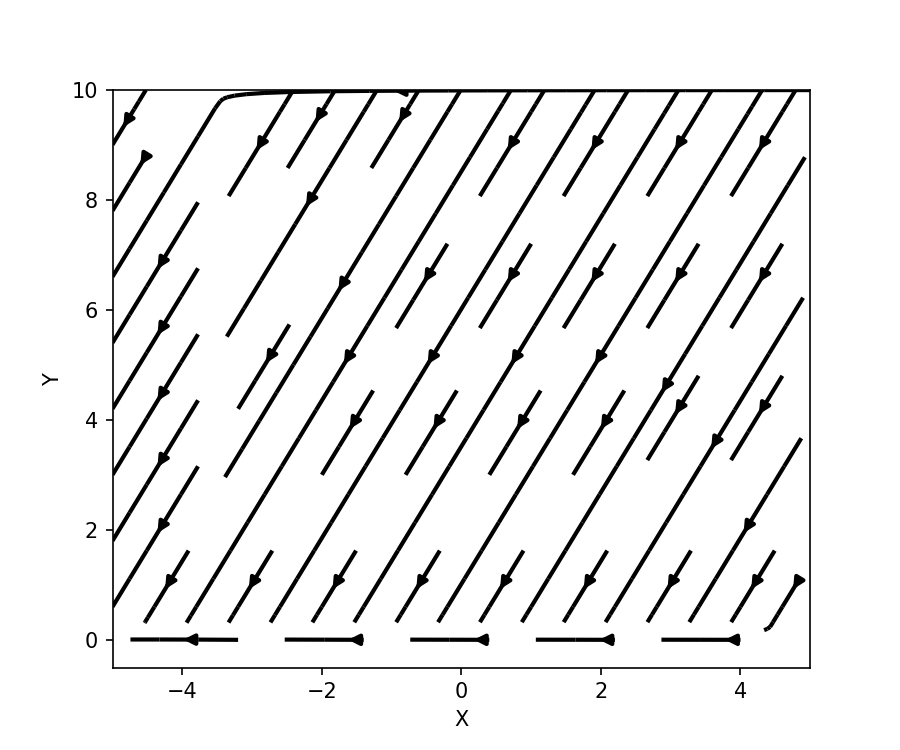

In [22]:
fig = pp.figure(figsize=(11, 7), dpi=100)

# pp.contourf(X, Y, T, alpha=0.5, cmap=cm.viridis)
# pp.colorbar()
# pp.contour(X, Y, T, cmap=cm.viridis)

pp.streamplot(X, Y, u, v, color='black', linewidth=2, density=0.6)
pp.xlabel('X')
pp.ylabel('Y');
fig = pp.gcf()
fig.set_size_inches(6, 5)